# Scatter Ptychography: a demo
### Qian Huang
### 03/14/2022

This notebook implements the phase retrieval algorithm in the paper *Scatter Ptychography*.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.measure import block_reduce
from scipy import ndimage

import torch
import torch.nn as nn
import torch.nn.functional as F

import random

_seed = 19971017

random.seed(_seed)
np.random.seed(_seed % 2**32)
torch.manual_seed(_seed)

device='cuda' ## set to 'cpu' if cuda is unavailable
target_name = 'usaf' # usaf, a, osc, or uoa

In [2]:
## helper functions

def print_stat(narray, narray_name = 'Array'):
    print(narray_name + f" shape: {narray.shape}, dtype: {narray.dtype}")
    arr = narray.flatten()
    print(narray_name + " stat: max: {}, min: {}, mean: {}, std: {}".format(arr.max(), arr.min(), arr.mean(), arr.std()))

def pad_to_size(img, size):
    h, w = img.shape
    left = (size - w)//2
    top = (size - h) //2
    return F.pad(img, (left, size-w-left, top, size-h-top))

def crop_to_size(img, size, offset=-1):
    h, w = img.shape
    left = (w - size)//2+offset 
    top = (h - size)//2+offset
    return img[top:top+size, left:left+size]

def show_stats(complex_img):
    plt.imshow(torch.abs(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Amplitude')
    plt.show()
    print_stat(torch.abs(complex_img),'Amplitude')
    plt.imshow(torch.angle(complex_img).to('cpu').numpy(), cmap='gray')
    plt.title('Phase')
    plt.show()
    print_stat(torch.angle(complex_img),'Phase')

In [3]:
## propagation models

def CUASD(f, d, lam, p):
    # INPUT
    ## f: input field
    ## d: distance in m
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    # OUTPUT
    ## g: output field
    pad = int((d*lam/p**2))//2*2+2 if d > 0 else 0
    inF = F.pad(f,(pad, pad, pad, pad))
    m, n = inF.size()
    urange = torch.linspace(-m/(2*p*m), (m-1)/(2*p*m), m).double()
    vrange = torch.linspace(-n/(2*p*n), (n-1)/(2*p*n), n).double()
    v, u = torch.meshgrid(vrange,urange)
    h = torch.exp(1j*2*np.pi*d*torch.sqrt((1/lam)**2 - u**2 - v**2)).to(device)
    g = torch.fft.ifft2(torch.fft.fftshift(h) * torch.fft.fft2(inF))
    return g

def cu_rescale(img, scale):
    return F.interpolate(img.unsqueeze(0).unsqueeze(0), scale_factor=scale,mode='bicubic').squeeze()

## MASM
def CUMASD(f, d, lam, p, x):
    # INPUT
    ## f: input field
    ## d: distance in m, positive
    ## lam: wavelength in m
    ## p: pixel pitch size in m
    ## x: object size in m
    # OUTPUT
    ## g: output field
    ## p_out: output field pixel pitch
    g = f
    p_out = p
    h_prev = 0
    while 2*(2*p_out)*x/lam*(p_out/p) < d:
        h = 2*(2*p_out)*x/lam*(p_out/p)
        g = CUASD(g, h-h_prev, lam, p_out)
        g = cu_rescale(torch.real(g),0.5)+1j*cu_rescale(torch.imag(g),0.5)
        h_prev = h
        p_out = 2*p_out
    g = CUASD(g, d-h_prev, lam, p_out)
    return g, p_out

## inverse MASM
def CURMASD(g, d, lam, p_out, p, x):
    # INPUT
    ## g: field to be back propagated
    ## d: reversal distance in m, positive
    ## lam: wavelength in m
    ## p_out: pixel pitch of g in m
    ## p: tolerable pixel pitch of f in m
    ## x: object size in m
    # OUTPUT
    ## f: reversed field
    ## p_in: pixel pitch of reversed field
    f = g
    p_in = p_out
    h_prev = d
    while p_in > p:
        h = 2*p_in*x/lam*(p_in/2/p)
        f = CUASD(f, h-h_prev, lam, p_in)
        pad = int((-(h-h_prev)*lam/p_in**2)//2*2+2)
        f = f[pad:-pad, pad:-pad]# remove padding
        f = cu_rescale(torch.real(f),2)+1j*cu_rescale(np.imag(f),2)
        h_prev = h
        p_in = p_in/2
    f = CUASD(f, -h_prev, lam, p_in)
    return f, p_in

## Phase Retrieval

#### load data

/home/u18/qh38/.local/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


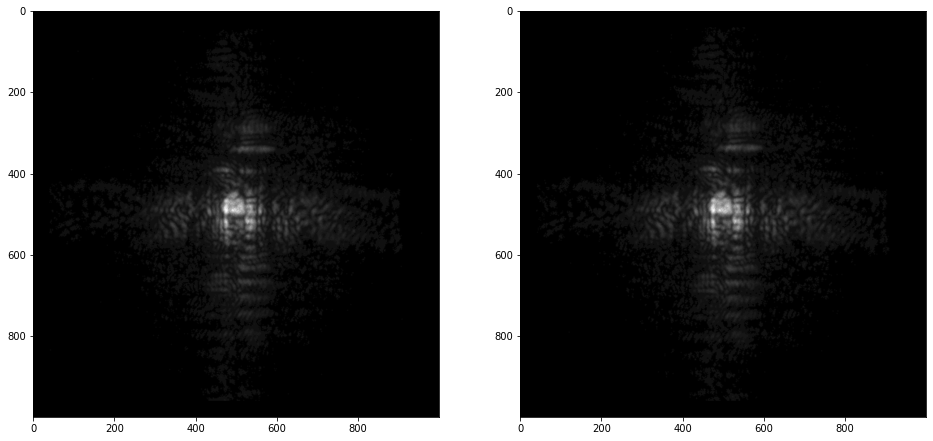

In [4]:
measurements=[]
z = []
k = 1
num_planes= 2
pad_to = [3220,3224,3224,3228,3232,3236,3240,3244,3244,3248,3252]
fig = plt.figure(figsize=(16, 8))
for offset in np.linspace(0, 50, num_planes):
    offset = int(offset)
    base = 104.5
    z.append((base*25.4+offset)*1e-3) ## propagation distance

    img = cv2.imread(f'datasets/{target_name}_{offset}mm.png', 0)/255.0
    img = np.sqrt(img) ## intensity to amplitude

    img = cu_rescale(torch.from_numpy(img).to(device), 2) ## projection
    img = pad_to_size(img, pad_to[offset//5])  ## add enough padding
    measurements.append(img)
    plt.subplot(1,num_planes,k)
    plt.imshow(crop_to_size(torch.abs(img).to('cpu').numpy(),1000,0),cmap='gray')
    k+=1
plt.show()

#### initialization

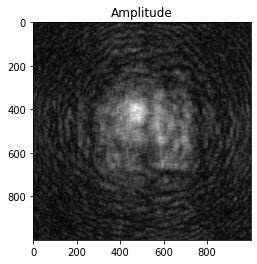

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 0.667615332017361, min: 3.096333966175051e-05, mean: 0.11166041780132502, std: 0.08139989541417325


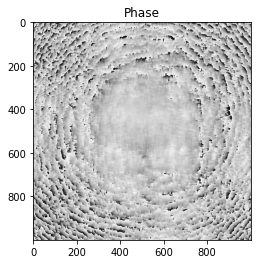

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415881845846076, min: -3.141586448047754, mean: 1.4222737438170345, std: 1.1929676668710392


In [5]:
unit = 10e-6
lam = 0.532e-6

index_c = 0
field_at_target_inv, p_in = CURMASD(torch.abs(measurements[index_c])*torch.exp(1j*(torch.randn_like(torch.abs(measurements[index_c])))), z[index_c], lam, 40e-6, unit, 4e-3)#ASD(measurements[index_c], -z[index_c], lam, unit)
show_stats(crop_to_size(field_at_target_inv, 1000, 0))

In [6]:
#### light: constant amplitude and phase

def calc_lf(N):
    theta = 1e-10
    urange=torch.arange(-N//2, N//2).double()
    vrange=torch.arange(-N//2, N//2).double()
    UU, VV = torch.meshgrid(vrange,urange)
    lf = torch.exp(1j*2*np.pi/lam*(UU*unit*np.sin(theta))).to(device)
    return lf

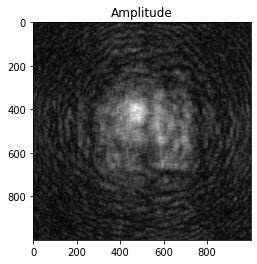

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 0.6676153320173611, min: 3.096333966175051e-05, mean: 0.11166041780132502, std: 0.08139989541417325


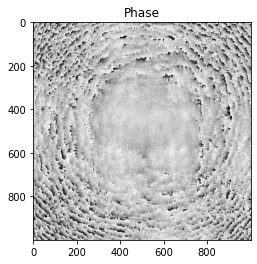

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415835903006144, min: -3.1415811215128415, mean: 1.422273749722284, std: 1.1929676623835217


In [7]:
target_est = field_at_target_inv/calc_lf(field_at_target_inv.shape[0])  ## initial estimation
target_est = crop_to_size(target_est, 1000, 0)
show_stats(target_est)

#### iterations

/home/u18/qh38/.local/lib/python3.6/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


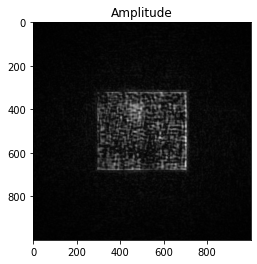

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.464011738524978, min: 2.0979560922879827e-05, mean: 0.12412037538188367, std: 0.2071298594484592


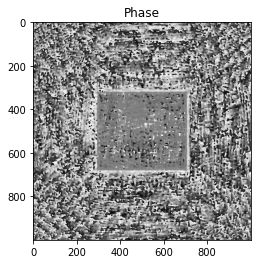

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415882165623525, min: -3.141561901871703, mean: 0.0685946197295777, std: 1.7040797172337052


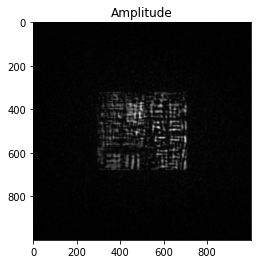

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.2328172890343376, min: 1.2032699692220424e-05, mean: 0.10017600097642723, std: 0.22303822992121686


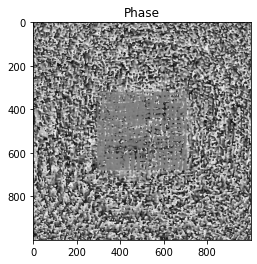

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415826043234056, min: -3.141579141804876, mean: 0.008499206959711469, std: 1.7137553651092814


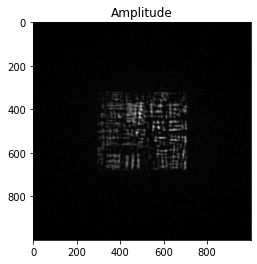

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.6642684091397797, min: 1.2787710092964189e-05, mean: 0.09678752127539055, std: 0.21962198243918293


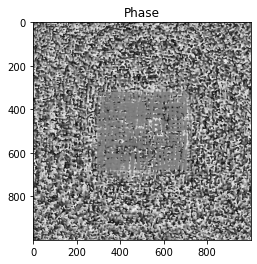

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141572422605671, min: -3.1415863830897237, mean: 0.011675074049371275, std: 1.7196142567824195


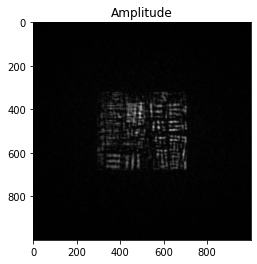

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 4.0051975169402745, min: 4.0476636929132974e-05, mean: 0.09667649511854891, std: 0.22472223602653674


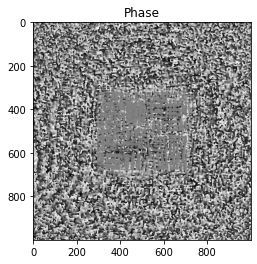

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141589502793883, min: -3.1415926018730396, mean: 0.0062148515743954465, std: 1.7179134503010347


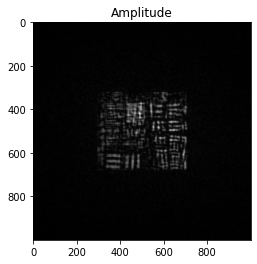

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.814317217957602, min: 2.278630591931491e-05, mean: 0.09637514954792735, std: 0.22486504346422212


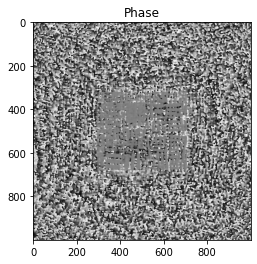

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415892702282484, min: -3.1415890397477493, mean: 0.0009989234064467928, std: 1.7173730092565764


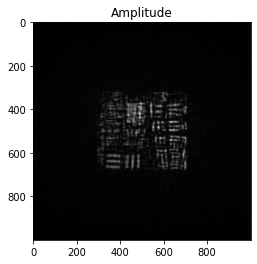

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.8120486427332425, min: 8.513902265361255e-05, mean: 0.09615402936147749, std: 0.2249722208440004


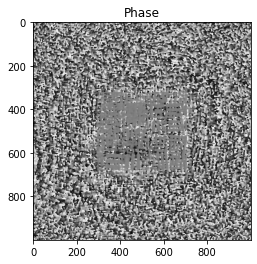

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415842307573603, min: -3.141576861872831, mean: -0.0052487206444112285, std: 1.7156823312722527


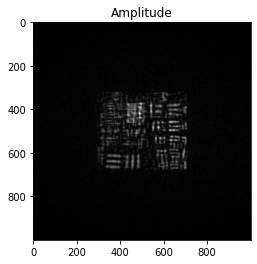

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.694660590167483, min: 4.360879505859274e-05, mean: 0.09586991771741561, std: 0.2250823341102215


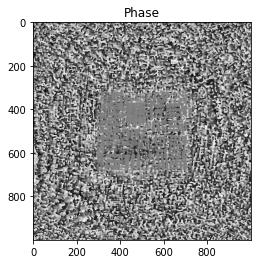

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415922982074718, min: -3.14157753069124, mean: -0.006720260459257113, std: 1.7149292119525308


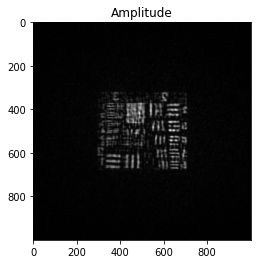

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 3.0326787791592147, min: 3.421311518702005e-05, mean: 0.09341684278083508, std: 0.22603022815647247


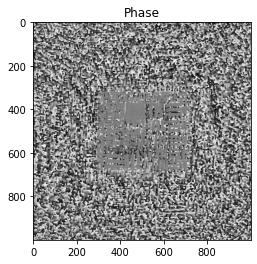

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141591472535585, min: -3.1415908088282283, mean: 0.004687547323801776, std: 1.7155521885358105


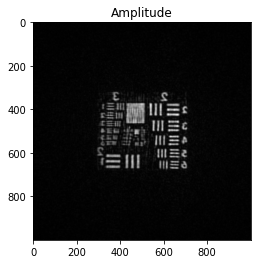

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.2395307202785175, min: 4.2227625398147854e-05, mean: 0.08704155706095913, std: 0.22865346516743754


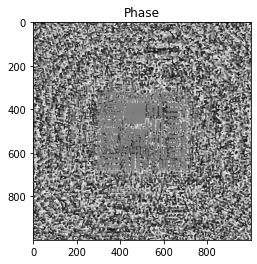

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.141583485496593, min: -3.1415876565656364, mean: -0.011431117212926398, std: 1.7146947486787025


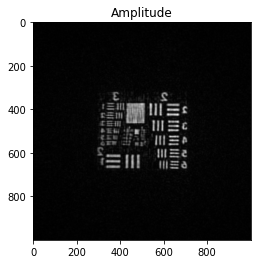

Amplitude shape: torch.Size([1000, 1000]), dtype: torch.float64
Amplitude stat: max: 2.2678202574782707, min: 1.2255625532834466e-05, mean: 0.08659906312082806, std: 0.22883615145470643


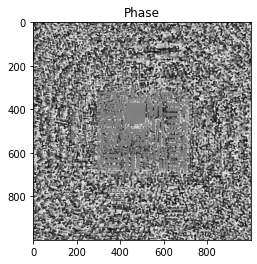

Phase shape: torch.Size([1000, 1000]), dtype: torch.float64
Phase stat: max: 3.1415910734854426, min: -3.141592434801187, mean: -0.014050289419610281, std: 1.7141392487343625


In [8]:
# %%time
measurements_est = [i.cdouble() for i in measurements]
n = 500
support_dict = {'usaf': (320,294), 'a': (320,300), 'osc': (290,300), 'uoa': (375,120)}
for iter in range(n):
    idx_list = list(range(num_planes))
    random.shuffle(idx_list)
    for i in idx_list:
        h_pad, w_pad = support_dict[target_name]
        target_est = torch.abs(target_est)
        target_est[:h_pad] = 1e-10
        target_est[-h_pad:] = 1e-10
        target_est[:,:w_pad] = 1e-10
        target_est[:,-w_pad:] = 1e-10
        field_at_target = calc_lf(1000)*target_est.cdouble()
        sc, p_out = CUMASD(field_at_target, z[i], lam, unit, 4e-3)
        measurements_est[i] = torch.abs(measurements[i]).cdouble()*torch.exp(1j*torch.angle(sc))
        field_at_target_inv, p_in = CURMASD(measurements_est[i], z[i], lam, p_out, unit, 4e-3)
        target_est = crop_to_size(field_at_target_inv/calc_lf(field_at_target_inv.shape[0]), 1000, 0)
    if iter % 50 == 0:
        show_stats(crop_to_size(target_est, 1000, 0))

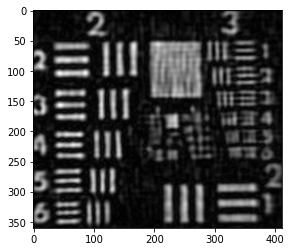

In [9]:
if target_name == 'usaf':
    plt.imshow(torch.abs(target_est).to('cpu').numpy()[h_pad:-h_pad, -w_pad:w_pad:-1], cmap='gray')
    plt.show()
else:
    plt.imshow(torch.abs(target_est).to('cpu').numpy()[h_pad:-h_pad, w_pad:-w_pad], cmap='gray')
    plt.show()